In [674]:
from ortools.sat.python import cp_model
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# River Crossing Problem

There were  three men, each having an unmarried sister, who needed to cross a river.   Each  man was desiring of  his friend's  sister.  Coming to the river, they  found only  a small boat in which only two persons could cross at a time. Let him say, he who is able, How did they cross the river, so that none of the sisters were defiled by other men?

This problem has 3 constraints:

1. The boat can only carry two people at a time.
2. The men cannot be in the presence of other women without those women's brothers present.
3. At least one person should be on the boat to go from one side to another.

In [675]:
# Creates the model and set solver
model = cp_model.CpModel()
solver = cp_model.CpSolver()

siblings = range(3)

Stages = range(12)

# Brothers variable
B = {(i,j,s): model.NewBoolVar(f'B_{i}_{j}_{s}') for i in siblings for j in range(2) for s in Stages}

# Sisters variable
S = {(i,j,s): model.NewBoolVar(f'S_{i}_{j}_{s}') for i in siblings for j in range(2) for s in Stages}

# Boat variable
boat = {(i,s): model.NewBoolVar(f'boat_{i}_{s}') for i in range(2) for s in Stages}

# Tracking when brothers move
moved_B = {(i,j,s): model.NewBoolVar(f'moved_B_{i}_{j}_{s}') for i in siblings for j in range(2) for s in Stages}

# Tracking when sisters move
moved_S = {(i,j,s): model.NewBoolVar(f'moved_S_{i}_{j}_{s}') for i in siblings for j in range(2) for s in Stages}

# Termination condition
term = {s: model.NewBoolVar(f'term_{s}') for s in Stages}

# Initializing
for i in siblings:
    model.Add(B[i,0,0] == 1)
    model.Add(B[i,1,0] == 0)
    model.Add(S[i,0,0] == 1)
    model.Add(S[i,1,0] == 0)
model.Add(boat[0,0] == 1)

# Must terminate at some point
model.AddAtLeastOne([term[s] for s in Stages])

# No termination at the first step
model.Add(term[1] == 0)

for s in Stages:

    # Final solution if terminated
    model.Add(sum(B[i,1,s] for i in siblings) == 3).OnlyEnforceIf(term[s])
    model.Add(sum(S[i,1,s] for i in siblings) == 3).OnlyEnforceIf(term[s])
    model.Add(boat[1,s] == 1).OnlyEnforceIf(term[s])

    # Boat only on one side of river
    model.AddExactlyOne([boat[i,s] for i in range(2)])

    if s > 0:
        if s != len(Stages):
            # If terminated, then next step also terminated
            model.Add(term[s-1] <= term[s])

        # At most 2 and at least 1 person(s) move
        model.Add(sum(moved_B[i,j,s] + moved_S[i,j,s] for i in siblings for j in range(2)) <= 4).OnlyEnforceIf(term[s].Not())
        model.Add(sum(moved_B[i,j,s] + moved_S[i,j,s] for i in siblings for j in range(2)) >= 2).OnlyEnforceIf(term[s].Not())

        # If terminated, then less than 2 people move
        model.Add(sum(moved_B[i,j,s] + moved_S[i,j,s] for i in siblings for j in range(2)) <= 4).OnlyEnforceIf(term[s])


        for i in siblings:
            # Each brother and sister only on one side of river
            model.AddExactlyOne([B[i,j,s] for j in range(2)])
            model.AddExactlyOne([S[i,j,s] for j in range(2)])

            for j in range(2):
                # If not terminated, then boat changes location at every stage, otherwise stays the same
                model.Add(boat[j,s-1].Not() == boat[j,s]).OnlyEnforceIf(term[s].Not())
                model.Add(boat[j,s-1] == boat[j,s]).OnlyEnforceIf(term[s],term[s-1])

                # Sisters can't be alone with men that aren't their brother
                model.Add(sum(B[a,j,s] for a in siblings if a != i) == 0).OnlyEnforceIf(S[i,j,s],B[i,j,s].Not())

                # Tracking when brothers and sisters move
                model.AddAbsEquality(moved_B[i,j,s], B[i,j,s-1] - B[i,j,s])
                model.AddAbsEquality(moved_S[i,j,s], S[i,j,s-1] - S[i,j,s])

                # Can't move if no boat 
                model.Add(B[i,j,s] == 1).OnlyEnforceIf(boat[j,s-1].Not(), B[i,j,s-1])
                model.Add(S[i,j,s] == 1).OnlyEnforceIf(boat[j,s-1].Not(), S[i,j,s-1])

# Solving
status = solver.Solve(model)
print(f"Status = {solver.StatusName(status)}")

Status = OPTIMAL


In [676]:
B_sol = [solver.value(B[i,j,s]) for s in Stages for i in siblings for j in range(2)]
B_sol = np.reshape(B_sol, (len(Stages),len(siblings),2))

S_sol = [solver.value(S[i,j,s]) for s in Stages for i in siblings for j in range(2)]
S_sol = np.reshape(S_sol, (len(Stages),len(siblings),2))

boat_sol = [solver.value(boat[i,s]) for s in Stages for i in range(2)]
boat_sol = np.reshape(boat_sol, (len(Stages),2))

moved_b_sol = [solver.value(moved_B[i,j,s]) for s in Stages for i in siblings for j in range(2)]
moved_b_sol = np.reshape(moved_b_sol, (len(Stages),len(siblings),2))

moved_s_sol = [solver.value(moved_S[i,j,s]) for s in Stages for i in siblings for j in range(2)]
moved_s_sol = np.reshape(moved_s_sol, (len(Stages),len(siblings),2))

final = [[B_sol[i],S_sol[i], boat_sol[i]] for i in range(len(B_sol))]


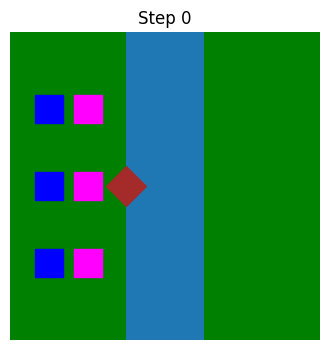

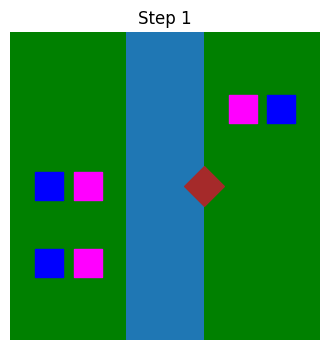

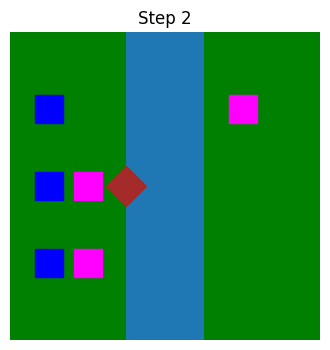

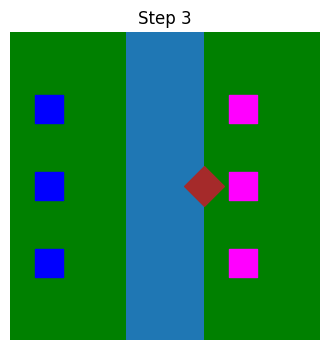

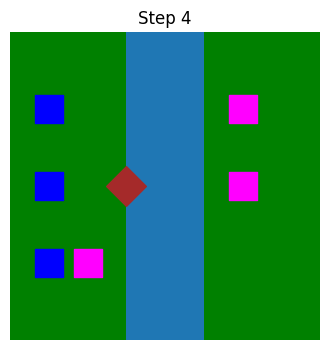

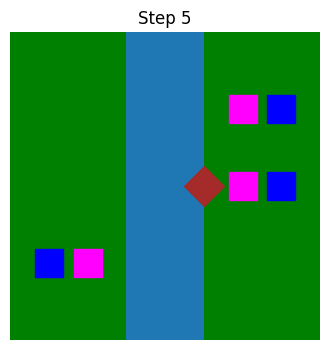

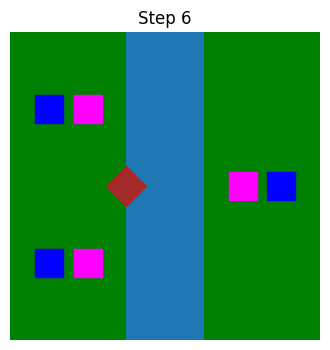

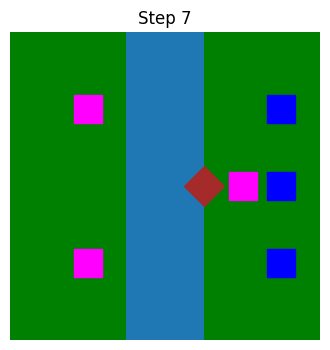

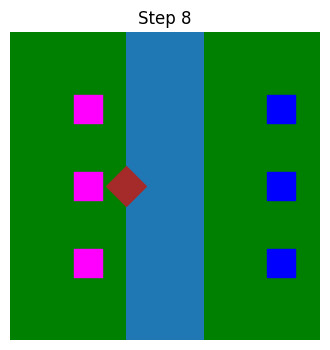

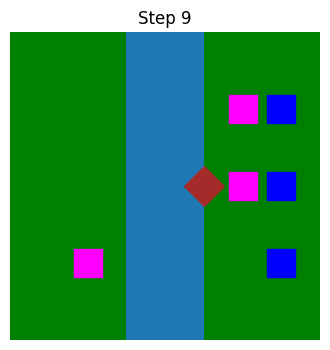

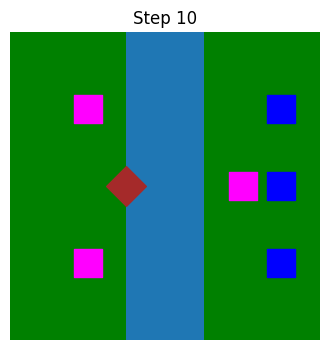

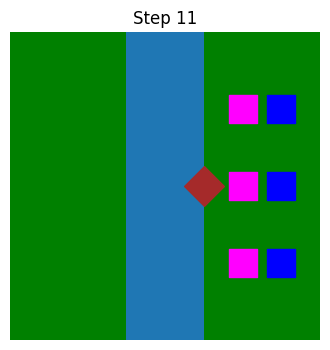

In [679]:
size = 400

for s in Stages:
    fig, ax = plt.subplots(figsize=(4,4));
    for i in range(len(final[s])):
        for j in range(len(final[s][i])):
                for k in range(2):
                    if i == 0:
                        if k == 0 and final[s][i][j][k] == 1:
                            ax.scatter(0,len(final[s][i]) - j, marker = 's', c='b', s = size);
                        elif k == 1 and final[s][i][j][k] == 1:
                            ax.scatter(6,len(final[s][i]) - j, marker = 's', c= 'b', s = size);
                    elif i == 1:
                        if k == 0 and final[s][i][j][k] == 1:
                            ax.scatter(1,len(final[s][i]) - j, marker = 's', c='fuchsia', s = size);
                        elif k == 1 and final[s][i][j][k] == 1:
                            ax.scatter(5,len(final[s][i]) - j, marker = 's', c='fuchsia', s = size);          
                    elif i == 2:
                        if k == 0 and int(final[s][i][k]) == 1:
                            ax.scatter(2,2, marker = 'D', c='brown', s = size);
                        elif k == 1 and int(final[s][i][k]) == 1:
                            ax.scatter(4,2, marker = 'D', c='brown', s = size);                    
    ax.set_xlim((-1,7));
    ax.set_ylim((0,4));
    ax.axis('off');
    ax.set_title(f'Step {s}')

    rect = Rectangle((2, 0), 2, 4, linewidth=1, zorder = -1)
    grass1 = Rectangle((-1, 0), 3, 4, linewidth=1, facecolor='green', zorder = -1)
    grass2 = Rectangle((4, 0), 3, 4, linewidth=1, facecolor='green', zorder = -1)
    ax.add_patch(rect);
    ax.add_patch(grass1);
    ax.add_patch(grass2);

    # plt.savefig(f'Step {s}.png', format='png')
    # plt.show();


![River Crossing Gif.gif](<attachment:River Crossing Gif.gif>)
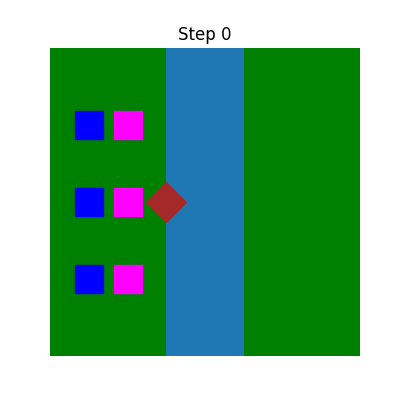